# Process Gajjar Bursts

This notebook computes the burst drift for the Gajjar bursts

In [1]:
#!/usr/bin/python3

from __future__ import division
import math
import os
import sys
import time
import numpy as np
import scipy.stats
from scipy.optimize import curve_fit
from math import log10
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import pi as nombrepi
from scipy import signal, ndimage
from tqdm import tqdm
from matplotlib import colors as mcolors
import functools
print = functools.partial(print, flush=True) # print doesn't happen til script ends so force it to flush... windows thing?
import pandas as pd
import corrfns

bursts = pd.read_csv('bursts.csv')



folder = 'data'
outfolder = 'figures'
for burst, filename, edge in tqdm( zip(range(1, len(bursts['filename'])+1), bursts['filename'], bursts['edge']), total=len(bursts['filename']) ):
    if 'gajjar' not in filename:
        continue
    if '11D' not in filename:
        continue
    print('processing {}'.format(filename))
    burst = '11D'


    # junk, nchan, nbin, I, Q, U, V = np.loadtxt('{}/{}'.format(folder, filename), delimiter=' ', unpack=True)
    # Q, U, V = None, None, None
    
    junk, nchan, nbin, I = [], [], [], []
    with open('{}/{}'.format(folder, filename)) as infile:
        for line in infile:
            junki, nchani, nbini, Ii, _, _, _ = line.split(' ')
            junk.append(junki)
            nchan.append(nchani)
            nbin.append(nbini)
            I.append(Ii)
    junk  = np.array(junk, dtype=float)
    nchan = np.array(nchan, dtype=float)
    nbin  = np.array(nbin, dtype=float)
    I     = np.array(I, dtype=float)
    
    n = len(junk)
    print("Data loaded")
    

    binmax = int(nbin[n-1])+1
    frequencymax = (int(nchan[n-1])+1)
    intensity = np.zeros((frequencymax, binmax))

    X = np.zeros(binmax)
    Y = np.zeros(frequencymax)

    # what are these?
    if burst == '11A':
        tmin, tmax = 1, 500
    elif burst == '11D':
        tmin, tmax = 1, 250
    else:
        tmin, tmax = 500, 1500

    #### 1. remove noise
    intensitynoise1 = np.zeros(tmin-1)
    intensitynoise2 = np.zeros(binmax-tmax)
    intensityraw = np.zeros((frequencymax, binmax))
    for i in tqdm(range(frequencymax-50,51,-1), desc='noise removal', disable=True):

        Y[i-1] = 4.15 + (i-1) * 1.5625 # ?

        for j in range(1,tmin) :
            intensitynoise1[j-1] = (I[j-1 + binmax*(frequencymax-i)])/(tmin-1)

        for j in range(tmax+1,binmax+1) :
            intensitynoise2[j-1-tmax] = (I[j-1 + binmax*(frequencymax-i)])/(binmax-tmax)

        a = sum(intensitynoise1)
        b = sum(intensitynoise2)

        for j in range(1,binmax+1) :
            X[j-1] = j-1
            intensity[i-1,j-1] = I[j-1 + binmax*(frequencymax-i)] - 1*(a+b)/2
            intensityraw[i-1,j-1] = I[j-1 + binmax*(frequencymax-i)]

    #### 2. find autocorrelation 
    #burstwindow = intensity[:,edge:edge+frequencymax]
    freqbot = 510
    freqtop = 2200
    if burst is '11A':
        tl, tr = 0, 150
    elif burst is '11D':
        tl, tr = 250, 400
    noise = intensity[freqbot:freqtop,0:40].mean(axis=1)[:, None]
    burstwindow = intensity[freqbot:freqtop,tl:tr] - 1*noise
    

<>:66: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:68: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:99: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:101: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:66: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:68: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:99: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:101: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-1-2ee3bfd8fe30>:66: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if burst is '11A':
<ipython-input-1-2ee3bfd8fe30>:68: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif burst is '11D':
<ipython-input-1-2ee3bfd8fe30>:99: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if burst is '11A':
<ipython-input-1-2ee3bfd8fe30>:101: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif burst is '11D':
  0%|          | 0/28 [00:00<?, ?it/s]

processing gajjar/11D_323sec.calib.4p.RM.scr.ASCII
Data loaded


100%|██████████| 28/28 [00:10<00:00,  2.59it/s]


finding auto-correlations...


B:\dev\sadtrombone\corrfns.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[0:nx,:] = result_shifted[nx-1:2*nx-1,:]
B:\dev\sadtrombone\corrfns.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[nx:2*nx-1,:] = result_shifted[0:nx-1,:]


finding auto-correlations...


B:\dev\sadtrombone\corrfns.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[0:nx,:] = result_shifted[nx-1:2*nx-1,:]
B:\dev\sadtrombone\corrfns.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[nx:2*nx-1,:] = result_shifted[0:nx-1,:]


[177272141.32111526]

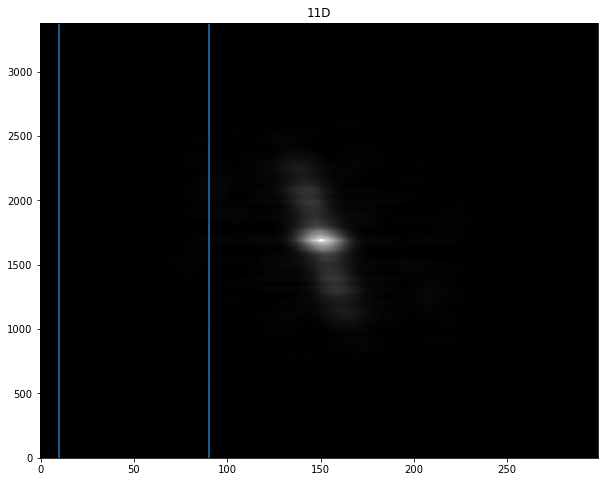

In [3]:
### Autocorrelation Noise
print("finding auto-correlations...")

corr = corrfns.auto_corr2D_viafft(burstwindow)

autocorrs = [corr]
titles = ['11D']
corredges = [(10, 90)]
sigmas = []

plt.figure(figsize=(10, 8))
for title, ac, corredge in zip(titles, autocorrs, corredges):
    plt.title(title)
    plt.imshow(ac, aspect='auto', interpolation='bicubic', origin='lower', cmap='gray')
    plt.axvline(x=corredge[0]); plt.axvline(x=corredge[1])
    plt.clim(0, np.max(ac)/8)
    autocorr_sigma = np.std( corr[:, corredge[0]:corredge[1]] )
    sigmas.append(autocorr_sigma)

sigmas

In [26]:
#### 3. Fit Gaussian to subburst autocorrelation
# popt, pcov = fitgaussian(corr) #  popt = [amplitude, xo, yo, sigma_x, sigma_y, theta]
# Gaussian 2d Fit Stuff Based on:
# Source: https://gist.github.com/andrewgiessel/6122739
# Source: https://stackoverflow.com/questions/21566379/fitting-a-2d-gaussian-function-using-scipy-optimize-curve-fit-valueerror-and-m
def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y, 2.0

def twoD_Gaussian(point, amplitude, xo, yo, sigma_x, sigma_y, theta):
    x, y = point
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = (np.sin(2*theta))/(2*sigma_x**2) - (np.sin(2*theta))/(2*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - a*((x-xo)**2) - b*(x-xo)*(y-yo) - c*((y-yo)**2))
    return g.ravel()

def fitgaussiannlsq(data, p0=[], sigma=0):
    # use curve-fit (non-linear leastsq)
    x, y = np.indices(data.shape)
    # x, y = np.meshgrid(range(0, data.shape[1]), range(0, data.shape[0]))
    p0 = moments(data) if p0 == [] else p0
    sigma = np.zeros(len(data.ravel())) + sigma
    popt, pcov = scipy.optimize.curve_fit(twoD_Gaussian, (x, y), data.ravel(), p0=p0, sigma=sigma, absolute_sigma=True)
    return popt, pcov

#  popt = [amplitude, xo, yo, sigma_x, sigma_y, theta]
popt, pcov = fitgaussiannlsq(corr, sigma=sigmas[0]) 
print('solution nlsq:', popt)



solution nlsq: [1.19922950e+10 1.68985623e+03 1.50496788e+02 8.63180591e+00
 2.56516288e+02 4.69137181e+00]


9648254.487519233 9.549748828354753


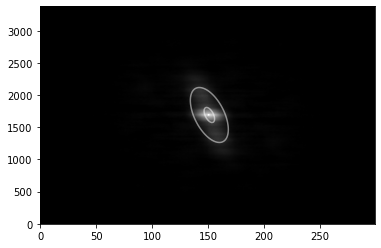

In [27]:
### Calculate Chisq
red_chisqs = []
for ac, sigma, popt in zip(autocorrs, sigmas, [popt]):
    f, t = np.indices(ac.shape)
    fitmap = twoD_Gaussian((f, t), *popt).reshape(ac.shape)
    residuals = ac - fitmap
    chisq = np.sum((residuals / sigma) ** 2)
    red_chisq = chisq / (ac.shape[0]*ac.shape[1] - len(popt)) # chisq/(M-N)
    red_chisqs.append(red_chisq)
    plt.imshow(ac, aspect='auto', interpolation='bicubic', origin='lower', cmap='gray')
    plt.clim(0, np.max(ac)/8)
    plt.contour(fitmap, [popt[0]/4, popt[0]*0.9], colors='w', alpha=0.5, origin='lower')
    
    print(chisq, red_chisq)


weighted center f: 6974.717930118591 	center channel: 1093.0741368276247


,angle,theta,slope,drift(MHz/ms),drift error,sigmax_error,sigmay_error,angle_error,red_chisq,center,center_f
11D,4.691372,1.591813,-47.573148,-1701.392924,0.967031,0.002164,0.064293,0.000012,9.549749,1093.074137,6974.71793


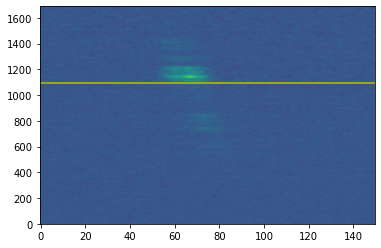

In [28]:
### 3.5 Compute drift and error for subbursts
perr = np.sqrt(np.diag(pcov))
thetas = -np.array([popt[-1]]) % (2*np.pi)
theta_errs = np.array([perr[-1]])
sigmax_errors = np.array([perr[3]])
sigmay_errors = np.array([perr[4]])
slopes = np.tan(thetas)

chan_width = 1.46484375 # MHz
time_resolution = 4.0958926622802e-5 # seconds
conversion = chan_width / (time_resolution*1e3)
drifts = conversion * slopes # MHz/ms
drift_errors = conversion * (theta_errs * (1/np.cos(thetas))**2)

lowestfreq = 6407.7148 - intensity.shape[0]/2*chan_width + chan_width*freqbot # MHz
for freqspectrum, c in zip([burstwindow], ['y']):
    freqspectrum = pd.DataFrame(freqspectrum[:,:].sum(axis=1)[:, None])
    data = freqspectrum[:][0]
    x = data.keys()
    xo = sum(x*data)/sum(data)
    plt.imshow(burstwindow, interpolation='bicubic', aspect='auto', origin='lower')
    plt.axhline(y=xo, c=c)
    
    print('weighted center f:', xo*chan_width + lowestfreq, '\tcenter channel:', xo)

driftresults = pd.DataFrame({
    'angle': [popt[-1]],
    'theta': thetas,
    'slope': slopes,
    'drift(MHz/ms)': drifts,
    'drift error': drift_errors,
    'sigmax_error': sigmax_errors,
    'sigmay_error': sigmay_errors,
    'angle_error': theta_errs,
    'red_chisq'  : red_chisqs,
    'center'     : xo,
    'center_f'   : xo*chan_width + lowestfreq
}, index=['11D'])

driftresults



In [21]:
solverdata = pd.DataFrame({
    '11D': popt
}, index=['amplitude', 'xo', 'yo', 'sigma_x', 'sigma_y', 'angle'])
solverdata

,11D
amplitude,1.199229e+10
xo,1.689856e+03
yo,1.504968e+02
sigma_x,8.631806e+00
sigma_y,2.565163e+02
angle,4.691372e+00


In [8]:
labelsize = 16
ticksize = 16
titlesize = 14

chan_width = 1.46484375 # MHz
time_resolution = 4.0958926622802e-5 # seconds
lowestfreq = 6407.7148 - intensity.shape[0]/2*chan_width + chan_width*freqbot # MHz

extents1a = [time_resolution * sub_1a[0] * 1e3, 
       time_resolution * sub_1a[1] * 1e3, # time, ms
       lowestfreq * 1e-3, # freq, GHz
       (lowestfreq + chan_width*burstwindow.shape[0]) * 1e-3]
extents1a = [time_resolution * sub_1a[0] * 1e3, 
       time_resolution * sub_1a[1] * 1e3, # time, ms
       lowestfreq * 1e-3, # freq, GHz
       (lowestfreq + chan_width*burstwindow.shape[0]) * 1e-3]
extents1b = [time_resolution * sub_1b[0] * 1e3, 
       time_resolution * sub_1b[1] * 1e3, # time, ms
       lowestfreq * 1e-3, # freq, GHz
       (lowestfreq + chan_width*burstwindow.shape[0]) * 1e-3]


corrextents1a = [-time_resolution * (sub1a_corr.shape[1]/2) * 1e3, 
       time_resolution * (sub1a_corr.shape[1]/2) * 1e3 , 
       - (extents1a[3] - extents1a[2])*1e3, 
        (extents1a[3] - extents1a[2])*1e3]
corrextents1b = [-time_resolution * (sub1b_corr.shape[1]/2) * 1e3, 
       time_resolution * (sub1b_corr.shape[1]/2) * 1e3 , 
       - (extents1a[3] - extents1a[2])*1e3, 
        (extents1a[3] - extents1a[2])*1e3]

plt.figure(figsize=(13, 13))
plt.subplot(221)
plt.title('Burst 11A-1a', size=titlesize, weight='bold')
plt.imshow(subburst_1a, aspect='auto', interpolation='bicubic', origin='lower', cmap='gray', extent=extents1a)
plt.ylabel("Frequency (MHz)", size=labelsize)
plt.xlabel("Time (ms)", size=labelsize)
plt.tick_params(labelsize=ticksize)

plt.subplot(222)
plt.title('Burst 11A-1b', size=titlesize, weight='bold')
plt.imshow(subburst_1b, aspect='auto', interpolation='bicubic', origin='lower', cmap='gray', extent=extents1b)
plt.ylabel("Frequency (MHz)", size=labelsize)
plt.xlabel("Time (ms)", size=labelsize)
plt.tick_params(labelsize=ticksize)

plt.subplot(223)
plt.title('Autocorrelation of 11A-1a: $d\\nu/d\\tau = ${:.2f} MHz/ms'.format(drifts[1]), size=titlesize, weight='bold')
f, t = np.indices(sub1a_corr.shape)
fitmap = twoD_Gaussian((f, t), *popt1a).reshape(sub1a_corr.shape)
plt.imshow(sub1a_corr, aspect='auto', interpolation='bicubic', origin='lower', cmap='gray', extent=corrextents1a)
plt.clim(0, np.max(sub1a_corr)/5)
plt.ylabel("Frequency Shift (MHz)", size=labelsize)
plt.xlabel("Time Shift (ms)", size=labelsize)
plt.contour(fitmap, [popt1a[0]/4, popt1a[0]*0.9], colors='w', alpha=0.5, origin='lower', extent=corrextents1a)
plt.tick_params(labelsize=ticksize)

plt.subplot(224)
plt.title('Autocorrelation of 11A-1b: $d\\nu/d\\tau = ${:.2f} MHz/ms'.format(drifts[2]), size=titlesize, weight='bold')
f, t = np.indices(sub1b_corr.shape)
fitmap = twoD_Gaussian((f, t), *popt1b).reshape(sub1b_corr.shape)
plt.imshow(sub1b_corr, aspect='auto', interpolation='bicubic', origin='lower', cmap='gray', extent=corrextents1b)
plt.clim(0, np.max(sub1b_corr)/5)
plt.contour(fitmap, [popt1b[0]/4, popt1b[0]*0.9], colors='w', alpha=0.5, origin='lower', extent=corrextents1b)
plt.ylabel("Frequency Shift (MHz)", size=labelsize)
plt.xlabel("Time Shift (ms)", size=labelsize)
plt.tick_params(labelsize=ticksize)

plt.tight_layout()
# plt.savefig('11A1subbursts_process.png')

NameError: name 'sub_1a' is not defined

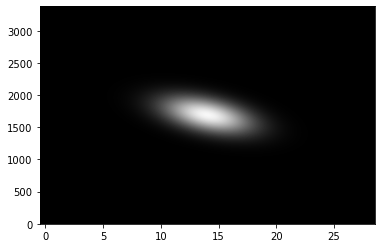

In [236]:
f, t = np.indices(sub1b_corr.shape)
testopts = np.array([2.91200986e+09, 1.68900000e+03, 1.40000000e+01, 1.94919922e+02, 2.27518615e+00, -0.006])
fitmap = twoD_Gaussian((f, t), *testopts).reshape(sub1b_corr.shape)
plt.imshow(fitmap, aspect='auto', interpolation='bicubic', origin='lower', cmap='gray')

In [9]:
extents1 = [time_resolution * sub_1[0] * 1e3, 
       time_resolution * sub_1[1] * 1e3, # time, ms
       lowestfreq * 1e-3, # freq, GHz
       (lowestfreq + chan_width*burstwindow.shape[0]) * 1e-3]
extents2 = [time_resolution * sub_2[0] * 1e3, 
       time_resolution * sub_2[1] * 1e3, # time, ms
       lowestfreq * 1e-3, # freq, GHz
       (lowestfreq + chan_width*burstwindow.shape[0]) * 1e-3]
extents3 = [time_resolution * sub_3[0] * 1e3, 
       time_resolution * sub_3[1] * 1e3, # time, ms
       lowestfreq * 1e-3, # freq, GHz
       (lowestfreq + chan_width*burstwindow.shape[0]) * 1e-3]

corrextents1 = [-time_resolution * (sub1_corr.shape[1]/2) * 1e3, 
       time_resolution * (sub1_corr.shape[1]/2) * 1e3 , 
       - (extents1[3] - extents1[2])*1e3, 
        (extents1[3] - extents1[2])*1e3]
corrextents2 = [-time_resolution * (sub2_corr.shape[1]/2) * 1e3, 
       time_resolution * (sub2_corr.shape[1]/2) * 1e3 , 
       - (extents1[3] - extents1[2])*1e3, 
        (extents1[3] - extents1[2])*1e3]
corrextents3 = [-time_resolution * (sub3_corr.shape[1]/2) * 1e3, 
       time_resolution * (sub3_corr.shape[1]/2) * 1e3 , 
       - (extents1[3] - extents1[2])*1e3, 
        (extents1[3] - extents1[2])*1e3]

plt.figure(figsize=(24, 16))
plt.subplot(231)
plt.title('Burst 11A1', size=titlesize, weight='bold')
plt.imshow(subburst_1, aspect='auto', interpolation='bicubic', origin='lower', cmap='gray', extent=extents1)
plt.ylabel("Frequency (MHz)", size=labelsize)
plt.xlabel("Time (ms)", size=labelsize)
plt.tick_params(labelsize=ticksize)

plt.subplot(232)
plt.title('Burst 11A2', size=titlesize, weight='bold')
plt.imshow(subburst_2, aspect='auto', interpolation='bicubic', origin='lower', cmap='gray', extent=extents2)
plt.ylabel("Frequency (MHz)", size=labelsize)
plt.xlabel("Time (ms)", size=labelsize)
plt.tick_params(labelsize=ticksize)

plt.subplot(233)
plt.title('Burst 11A3', size=titlesize, weight='bold')
plt.imshow(subburst_3, aspect='auto', interpolation='bicubic', origin='lower', cmap='gray', extent=extents3)
plt.ylabel("Frequency (MHz)", size=labelsize)
plt.xlabel("Time (ms)", size=labelsize)
plt.tick_params(labelsize=ticksize)

plt.subplot(234)
plt.title('Autocorrelation of 11A1: $d\\nu/d\\tau = ${:.2f} MHz/ms'.format(drifts[0]), size=titlesize, weight='bold')
f, t = np.indices(sub1_corr.shape)
fitmap = twoD_Gaussian((f, t), *popt1).reshape(sub1_corr.shape)
plt.imshow(sub1_corr, aspect='auto', interpolation='bicubic', origin='lower', cmap='gray', extent=corrextents1)
plt.clim(0, np.max(sub1_corr)/10)
plt.contour(fitmap, [popt1[0]/4, popt1[0]*0.9], colors='w', alpha=0.5, origin='lower', extent=corrextents1)
plt.ylabel("Frequency Shift (MHz)", size=labelsize)
plt.xlabel("Time Shift (ms)", size=labelsize)
plt.tick_params(labelsize=ticksize)


plt.subplot(235)
plt.title('Autocorrelation of 11A2: $d\\nu/d\\tau = ${:.2f} MHz/ms'.format(drifts[3]), size=titlesize, weight='bold')
f, t = np.indices(sub2_corr.shape)
fitmap = twoD_Gaussian((f, t), *popt2).reshape(sub2_corr.shape)
plt.imshow(sub2_corr, aspect='auto', interpolation='bicubic', origin='lower', cmap='gray', extent=corrextents2)
plt.clim(0, np.max(sub2_corr)/10)
plt.contour(fitmap, [popt2[0]/4, popt2[0]*0.9], colors='w', alpha=0.5, origin='lower', extent=corrextents2)
plt.ylabel("Frequency Shift (MHz)", size=labelsize)
plt.xlabel("Time Shift (ms)", size=labelsize)
plt.tick_params(labelsize=ticksize)

plt.subplot(236)
plt.title('Autocorrelation of 11A3: $d\\nu/d\\tau = ${:.2f} MHz/ms'.format(drifts[4]), size=titlesize, weight='bold')
f, t = np.indices(sub3_corr.shape)
fitmap = twoD_Gaussian((f, t), *popt3).reshape(sub3_corr.shape)
plt.imshow(sub3_corr, aspect='auto', interpolation='bicubic', origin='lower', cmap='gray', extent=corrextents3)
plt.clim(0, np.max(sub3_corr)/10)
plt.contour(fitmap, [popt3[0]/4, popt3[0]*0.9], colors='w', alpha=0.5, origin='lower', extent=corrextents3)
plt.ylabel("Frequency Shift (MHz)", size=labelsize)
plt.xlabel("Time Shift (ms)", size=labelsize)
plt.tick_params(labelsize=ticksize)

plt.tight_layout()
# plt.savefig('11Asubbursts_process.png')

NameError: name 'sub_1' is not defined

In [10]:
solverdata = pd.DataFrame({
    '1': popt1,
    '1a': popt1a,
    '1b': popt1b,
    '2': popt2,
    '3': popt3,
}, index=['amplitude', 'xo', 'yo', 'sigma_x', 'sigma_y', 'angle'])
solverdata

NameError: name 'popt1' is not defined

In [22]:
    #### 3. Fit Gaussian to autocorrelation
    print(corr.shape)
    # popt, pcov = fitgaussian(corr) #  popt = [amplitude, xo, yo, sigma_x, sigma_y, theta]

    popt, pcov = fitgaussiannlsq(corr) #  popt = [amplitude, xo, yo, sigma_x, sigma_y, theta]
    perr = np.sqrt(np.diag(pcov))

    print('solution nlsq:', popt)
    # print('parameter cov:', pcov)
    print('parameter 1sigma:', perr)
    

(3379, 299)


C:\Users\hmsmo\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\minpack.py:734: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma


solution nlsq: [2.22919191e+11 1.69000681e+03 1.50493148e+02 1.61737621e+03
 1.54019171e+03 2.00000000e+00]
parameter 1sigma: [inf inf inf inf inf inf]


C:\Users\hmsmo\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [29]:
    f, t = np.indices(corr.shape)
    fitmap2 = twoD_Gaussian((f, t), *popt).reshape(corr.shape)
    print(fitmap2.shape, corr.shape, f.shape, t.shape)
    ### 3.5 Compute drift and error
    chan_width = 1.46484375 # MHz
    time_resolution = 4.0958926622802e-5 # seconds
    # theta = popt[-1] if abs(popt[3]) > abs(popt[4]) else popt[-1] - np.pi/2
    theta = 2*np.pi - popt[-1] # for 11D: solver finds angle CW from pos x axis
    
    slope = np.tan(theta)
    print('solver angle:', popt[-1], 'pos angle:', theta)
    conversion = chan_width / (time_resolution*1e3)
    drift = conversion * slope # MHz/ms
    drift_error = conversion * (perr[-1] * (1/np.cos(theta))**2)
    print('drift error:', drift_error)
    

(3379, 299) (3379, 299) (3379, 299) (3379, 299)
solver angle: 4.691371814070877 pos angle: 1.5918134931087096
drift error: 0.9670309305532995


theta 1.5918134931087096
[-6.123359530108899, 6.123359530108899, -2475.5859375, 2475.5859375]


<Figure size 1224x576 with 0 Axes>

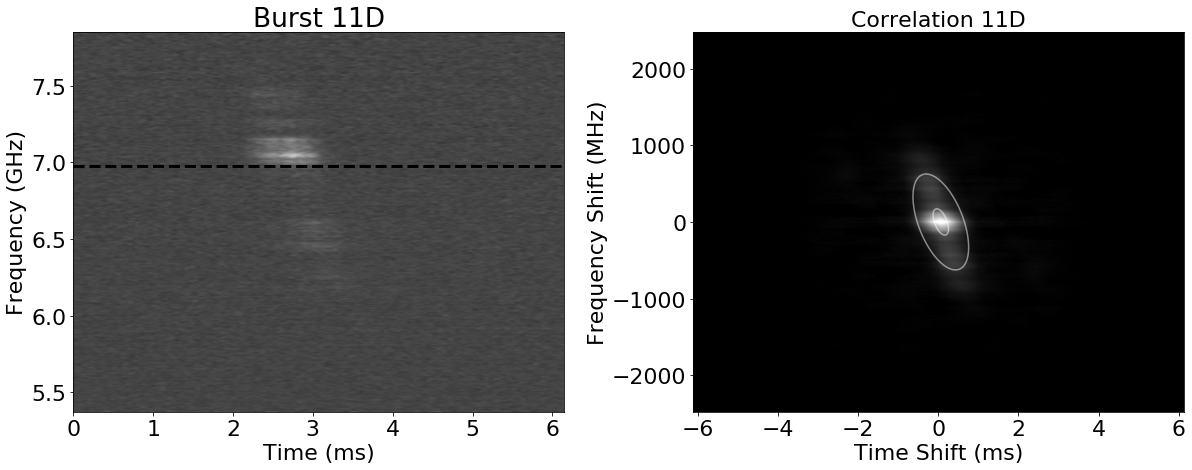

In [42]:
    #### 4. Plot
    cmap = plt.get_cmap('gray')
    cmap.set_bad(color = 'b', alpha = 1.) # potentially hides important errors in the data!
    fontsize = 22
    plt.rcParams.update({'font.size': fontsize})
    
    plt.figure(figsize=(17,8))
    plt.figure(figsize=(8.5*2, 11*2-15))
    plt.subplot(121)
    plt.title("Burst 11D")
    
    lowestfreq = 6407.7148 - intensity.shape[0]/2*chan_width + chan_width*freqbot # MHz
    print('theta', theta)
    burstextents = [0, 
           time_resolution * burstwindow.shape[1] * 1e3, # time, ms
           lowestfreq * 1e-3, # freq, GHz
           (lowestfreq + chan_width*burstwindow.shape[0]) * 1e-3]
    plt.imshow(burstwindow, cmap=cmap, interpolation='bicubic', aspect='auto', origin="lower", extent=burstextents)
    plt.axhline(y=6974.7/1000, c='k', ls='--', lw=3)
    # plt.clim(0, np.max(burstwindow))
    plt.xlabel("Time (ms)")
    plt.ylabel("Frequency (GHz)")
    # plt.colorbar()

    plt.subplot(122)
    #plt.title("Corr {}. Fit: $\\nu_D$ = {:.2f} MHz/ms $\pm$ {:.2E}, $\sigma_x$ = {:.0f} $\sigma_y$ = {:.0f}".format(burst, drift, drift_error, popt[3], popt[4]))
    plt.title("Correlation 11D", fontsize=fontsize)
    corrextents = [-time_resolution * (corr.shape[1]/2) * 1e3, 
           time_resolution * (corr.shape[1]/2) * 1e3 , 
           - (burstextents[3] - burstextents[2])*1e3, 
           (burstextents[3] - burstextents[2])*1e3]
    print(corrextents)
    plt.imshow(corr, cmap=cmap, interpolation='bicubic', aspect='auto', origin="lower", extent=corrextents)
    plt.clim(0, np.max(corr)/10)
    
    plt.xlabel("Time Shift (ms)")
    plt.ylabel("Frequency Shift (MHz)")
    # plt.colorbar()
    
    plt.contour(fitmap2, [popt[0]/4, popt[0]*0.9], colors='w', alpha=0.5, origin='lower', extent=corrextents)

    plt.tight_layout()
    plt.savefig('{}/gajjar11D.pdf'.format(outfolder, burst))
    #print('saved {}/burst_{}_figure.png'.format(outfolder, burst))

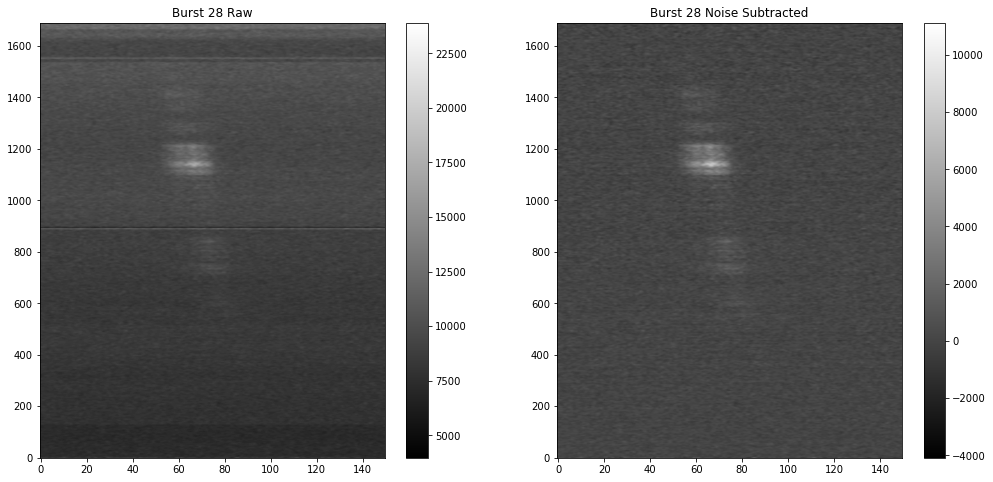

In [14]:
cmap = plt.get_cmap('gray')
# cmap.set_bad(color = 'k', alpha = 1.) # potentially hides important errors in the data!
tl,tr = 250,400
plt.figure(figsize=(17,8))

plt.subplot(121)
plt.title("Burst {} Raw".format(burst))
plt.imshow(intensityraw[510:2200,tl:tr], cmap=cmap, interpolation='bicubic',aspect='auto', origin="lower")
plt.colorbar()

plt.subplot(122)
plt.title("Burst {} Noise Subtracted".format(burst))
# burstextents = [0, 
#        10.24e-6 * burstwindow.shape[-1] * 1e3, 
#        4100.78125 * 1e-3, 
#        (4100.78125 + 1.5625*burstwindow.shape[-2]) * 1e-3]
# plt.imshow(burstwindow, cmap=cmap, interpolation='bicubic',aspect='auto', origin="lower", extent=burstextents)

freqbot = 510
freqtop = 2200
noise = intensity[freqbot:freqtop,0:40].mean(axis=1)[:, None]
burstwindow = intensity[freqbot:freqtop,tl:tr] - 1*noise
plt.imshow(burstwindow, cmap=cmap, interpolation='bicubic',aspect='auto', origin="lower")
# plt.xlabel("Time (ms)", size=15)
# plt.ylabel("Frequency (GHz)", size=15)
plt.colorbar()
# plt.clim(0, 25000)
plt.savefig('11Dnoise.png')

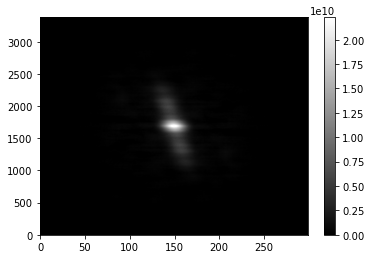

In [28]:
plt.imshow(corr, cmap=cmap, interpolation='bicubic', aspect='auto', origin="lower")
plt.clim(0, np.max(corr)/10)
plt.colorbar()